# K Nearest Neighbor on CIFAR 10

In [83]:
# # k-Nearest Neighbor (kNN) exercise
# 
# *Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*
# 
# The kNN classifier consists of two stages:
# 
# - During training, the classifier takes the training data and simply remembers it
# - During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
# - The value of k is cross-validated
 

import cPickle as pickle
import numpy as np
import os
from scipy.misc import imread

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = pickle.load(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

In [48]:
import random
import numpy as np
#from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
get_ipython().magic(u'matplotlib inline')
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
get_ipython().magic(u'load_ext autoreload')
get_ipython().magic(u'autoreload 2')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the CIFAR 10 data

In [49]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'datasets\CIFAR10'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)


#Expected behaviour - Training data has 50000 samples, each 32-cross-32 pixels (3 layers)
# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape


Training data shape:  (50000L, 32L, 32L, 3L)
Training labels shape:  (50000L,)
Test data shape:  (10000L, 32L, 32L, 3L)
Test labels shape:  (10000L,)


## Visualize few images from the dataset

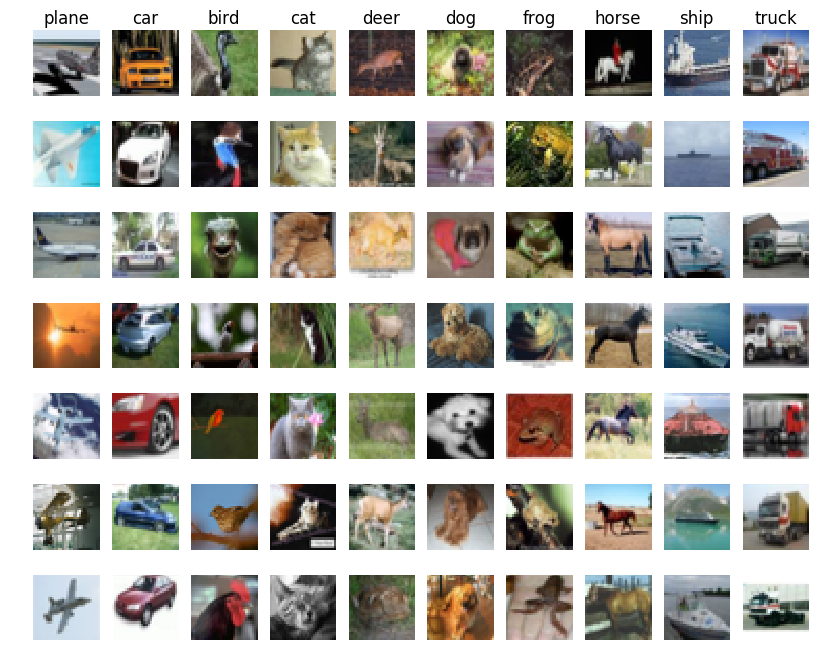

In [50]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()


In [51]:
# Subsample the data for more efficient code execution in this exercise
num_training = 500
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 50
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]


In [52]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print X_train.shape, X_test.shape

(500L, 3072L) (50L, 3072L)


## K Nearst Neighbor Class definition

In [55]:
import numpy as np
from collections import Counter
import time

class KNearestNeighbor(object):
  """ a kNN classifier with L2 distance """

  def __init__(self):
    pass

  def train(self, X, y):
    """
    Train the classifier. For k-nearest neighbors this is just 
    memorizing the training data.
    Inputs:
    - X: A numpy array of shape (num_train, D) containing the training data
      consisting of num_train samples each of dimension D.
    - y: A numpy array of shape (N,) containing the training labels, where
         y[i] is the label for X[i].
    """
    self.X_train = X
    self.y_train = y
    
  def predict(self, X, k=1, num_loops=0):
    """
    Predict labels for test data using this classifier.
    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data consisting
         of num_test samples each of dimension D.
    - k: The number of nearest neighbors that vote for the predicted labels.
    - num_loops: Determines which implementation to use to compute distances
      between training points and testing points.
    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
    if num_loops == 0:
      dists = self.compute_distances_no_loops(X)
    elif num_loops == 1:
      dists = self.compute_distances_one_loop(X)
    elif num_loops == 2:
      dists = self.compute_distances_two_loops(X)
    else:
      raise ValueError('Invalid value %d for num_loops' % num_loops)

    return self.predict_labels(dists, k=k)

  def compute_distances_two_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a nested loop over both the training data and the 
    test data.
    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data.
    Returns:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      is the Euclidean distance between the ith test point and the jth training
      point.
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in xrange(num_test):
      if i%100 == 0:
          print("Computeing Dist",i)
      for j in xrange(num_train):
        #####################################################################
        # TODO:                                                             #
        # Compute the l2 distance between the ith test point and the jth    #
        # training point, and store the result in dists[i, j]. You should   #
        # not use a loop over dimension.                                    #
        #####################################################################
        dists[i][j] = np.linalg.norm(X[i] - self.X_train[j])
        #####################################################################
        #                       END OF YOUR CODE                            #
        #####################################################################
    return dists

  def compute_distances_one_loop(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a single loop over the test data.
    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in xrange(num_test):
      #######################################################################
      # TODO:                                                               #
      # Compute the l2 distance between the ith test point and all training #
      # points, and store the result in dists[i, :].                        #
      #######################################################################
      tic = time.time()
      cloned_array = np.array([X[i]]*num_train)
      toc = time.time()
      print("time", toc-tic)
      print("shape",self.X_train.shape)
      print("shape",cloned_array.shape)
      dists[i] = np.linalg.norm(self.X_train-cloned_array, axis = 1)
      
      #######################################################################
      #                         END OF YOUR CODE                            #
      #######################################################################
    return dists

  def compute_distances_no_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using no explicit loops.
    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train)) 
    #########################################################################
    # TODO:                                                                 #
    # Compute the l2 distance between all test points and all training      #
    # points without using any explicit loops, and store the result in      #
    # dists.                                                                #
    #                                                                       #
    # You should implement this function using only basic array operations; #
    # in particular you should not use functions from scipy.                #
    #                                                                       #
    # HINT: Try to formulate the l2 distance using matrix multiplication    #
    #       and two broadcast sums.                                         #
    #########################################################################
    X_train_2 = self.X_train*self.X_train
    X_train_2 = np.sum(X_train_2, axis = 1)
    
    X_train_2_repeat = np.array([X_train_2]*X.shape[0])
    
    X_2 = X*X
    X_2 = np.sum(X_2, axis = 1)
    X_2_repeat = np.array( [X_2]*self.X_train.shape[0]).transpose()
    
    X_dot_X_train = X.dot(self.X_train.T)
    
#     print X_train_2_repeat.shape
#     print X_2_repeat.shape
#     print X_dot_X_train.shape
#     
#     
#     print X_train_2_repeat ,"\n"
#     print X_2_repeat ,"\n"
#     print 2*X_dot_X_train
    dists = X_train_2_repeat + X_2_repeat - 2*X_dot_X_train
    dists = np.sqrt(dists)
    
    #########################################################################
    #                         END OF YOUR CODE                              #
    #########################################################################
    return dists

  def predict_labels(self, dists, k=1):
    """
    Given a matrix of distances between test points and training points,
    predict a label for each test point.
    Inputs:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      gives the distance betwen the ith test point and the jth training point.
    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    for i in xrange(num_test):
      # A list of length k storing the labels of the k nearest neighbors to
      # the ith test point.
      #########################################################################
      # TODO:                                                                 #
      # Use the distance matrix to find the k nearest neighbors of the ith    #
      # testing point, and use self.y_train to find the labels of these       #
      # neighbors. Store these labels in closest_y.                           #
      # Hint: Look up the function numpy.argsort.                             #
      #########################################################################
      dists_i = dists[i]
      closest_y = self.y_train[dists_i.argsort()[:k]]
      
      #########################################################################
      # TODO:                                                                 #
      # Now that you have found the labels of the k nearest neighbors, you    #
      # need to find the most common label in the list closest_y of labels.   #
      # Store this label in y_pred[i]. Break ties by choosing the smaller     #
      # label.                                                                #
      
      #########################################################################
      y_pred[i] = Counter(closest_y).most_common(1)[0][0]
      #########################################################################
      #                           END OF YOUR CODE                            # 
      #########################################################################

    return y_pred

## Create a Class Object

In [56]:
#from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

In [57]:
#VIVEK TEST
print classifier


# We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 
# 
# 1. First we must compute the distances between all test examples and all train examples. 
# 2. Given these distances, for each test example we find the k nearest examples and have them vote for the label
# 
# Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.
# 
# First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [58]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print dists.shape


('Computeing Dist', 0)
(50L, 500L)


In [59]:
print (dists)#X_train1, y_train1, X_test1, y_test1 = load_CIFAR10(cifar10_dir)

[[ 3803.92350081  4210.59603857  5504.0544147  ...,  4982.62521167
   4867.38225333  3941.74504503]
 [ 6336.83367306  5270.28006846  4040.63608854 ...,  3962.81200664
   4672.05597141  5217.12554957]
 [ 5224.83913628  4250.64289255  3773.94581307 ...,  4041.67193127
   4685.40137021  4264.04338627]
 ..., 
 [ 3856.42230571  4291.71597383  5212.69623132 ...,  4931.70589147
   4846.80131633  3474.47535608]
 [ 2863.12696191  3984.09199191  5628.84206565 ...,  4921.71880546
   4469.54158723  3883.78397957]
 [ 2914.81628924  4314.15240806  5279.99441288 ...,  5381.81214834
   4836.07340722  3473.03181673]]


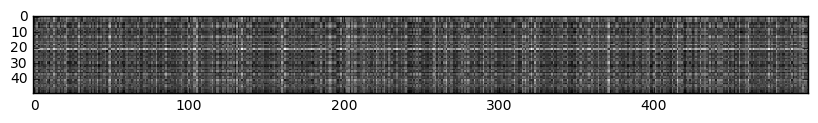

In [60]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

## Test the Classifier for differect K values

In [84]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)



Got 13 / 100 correct => accuracy: 0.130000


In [85]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)



Got 7 / 100 correct => accuracy: 0.070000


In [63]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print 'Difference was: %f' % (difference, )
if difference < 0.001:
  print 'Good! The distance matrices are the same'
else:
  print 'Uh-oh! The distance matrices are different'

('time', 0.02500009536743164)
('shape', (500L, 3072L))
('shape', (500L, 3072L))
('time', 0.03299999237060547)
('shape', (500L, 3072L))
('shape', (500L, 3072L))
('time', 0.03600001335144043)
('shape', (500L, 3072L))
('shape', (500L, 3072L))
('time', 0.031000137329101562)
('shape', (500L, 3072L))
('shape', (500L, 3072L))
('time', 0.03900003433227539)
('shape', (500L, 3072L))
('shape', (500L, 3072L))
('time', 0.034999847412109375)
('shape', (500L, 3072L))
('shape', (500L, 3072L))
('time', 0.03400015830993652)
('shape', (500L, 3072L))
('shape', (500L, 3072L))
('time', 0.03299999237060547)
('shape', (500L, 3072L))
('shape', (500L, 3072L))
('time', 0.03900003433227539)
('shape', (500L, 3072L))
('shape', (500L, 3072L))
('time', 0.03399991989135742)
('shape', (500L, 3072L))
('shape', (500L, 3072L))
('time', 0.026999950408935547)
('shape', (500L, 3072L))
('shape', (500L, 3072L))
('time', 0.037000179290771484)
('shape', (500L, 3072L))
('shape', (500L, 3072L))
('time', 0.06500005722045898)
('shap

In [64]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print 'Difference was: %f' % (difference, )
if difference < 0.001:
  print 'Good! The distance matrices are the same'
else:
  print 'Uh-oh! The distance matrices are different'

Difference was: 0.000000
Good! The distance matrices are the same


In [65]:
# Let's compare how fast the implementations are
def time_function(f, *args):
  """
  Call a function f with args and return the time (in seconds) that it took to execute.
  """
  import time
  tic = time.time()
  f(*args)
  toc = time.time()
  return toc - tic

train_time = time_function(classifier.train, X_train, y_train)
print 'Training time took %f seconds' % train_time


two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print 'Two loop version took %f seconds' % two_loop_time


one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print 'One loop version took %f seconds' % one_loop_time

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print 'No loop version took %f seconds' % no_loop_time

# you should see significantly faster performance with the fully vectorized implementation


# ### Cross-validation
# 
# We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.


Training time took 0.000000 seconds
('Computeing Dist', 0)
Two loop version took 2.108000 seconds
('time', 0.0279998779296875)
('shape', (500L, 3072L))
('shape', (500L, 3072L))
('time', 0.0280001163482666)
('shape', (500L, 3072L))
('shape', (500L, 3072L))
('time', 0.037000179290771484)
('shape', (500L, 3072L))
('shape', (500L, 3072L))
('time', 0.03500008583068848)
('shape', (500L, 3072L))
('shape', (500L, 3072L))
('time', 0.0280001163482666)
('shape', (500L, 3072L))
('shape', (500L, 3072L))
('time', 0.037000179290771484)
('shape', (500L, 3072L))
('shape', (500L, 3072L))
('time', 0.04900002479553223)
('shape', (500L, 3072L))
('shape', (500L, 3072L))
('time', 0.03899979591369629)
('shape', (500L, 3072L))
('shape', (500L, 3072L))
('time', 0.03299999237060547)
('shape', (500L, 3072L))
('shape', (500L, 3072L))
('time', 0.042999982833862305)
('shape', (500L, 3072L))
('shape', (500L, 3072L))
('time', 0.03500008583068848)
('shape', (500L, 3072L))
('shape', (500L, 3072L))
('time', 0.03399991989

## Test the Performance of Classifier for different Values of K

In [66]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################

range_split = np.array_split(range(X_train.shape[0]), num_folds)
y_train_folds = [ y_train[range_split[i]] for i in range(num_folds)]
X_train_folds = [ X_train[range_split[i]] for i in range(num_folds)]
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
for k in k_choices:
    for fold in range(num_folds): #This fold will be omitted.
        #Creating validation data and temp training data
        validation_X_test = X_train_folds[fold]
        validation_y_test = y_train_folds[fold]
        temp_X_train = np.concatenate(X_train_folds[:fold] + X_train_folds[fold + 1:])
        temp_y_train = np.concatenate(y_train_folds[:fold] + y_train_folds[fold + 1:])

        #Initializing a class
        test_classifier = KNearestNeighbor()
        test_classifier.train( temp_X_train, temp_y_train )
        
        #Computing the distance
        temp_dists = test_classifier.compute_distances_two_loops(validation_X_test)
        temp_y_test_pred = test_classifier.predict_labels(temp_dists, k=k)
        
        #Checking accuracies
        num_correct = np.sum(temp_y_test_pred == validation_y_test)
        num_test = validation_X_test.shape[0]
        accuracy = float(num_correct) / num_test
        k_to_accuracies[k] = k_to_accuracies.get(k,[]) + [accuracy]
    


################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
      print 'k = %d, accuracy = %f' % (k, accuracy)

('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computeing Dist', 0)
('Computein

## Cross Validation Accuracy

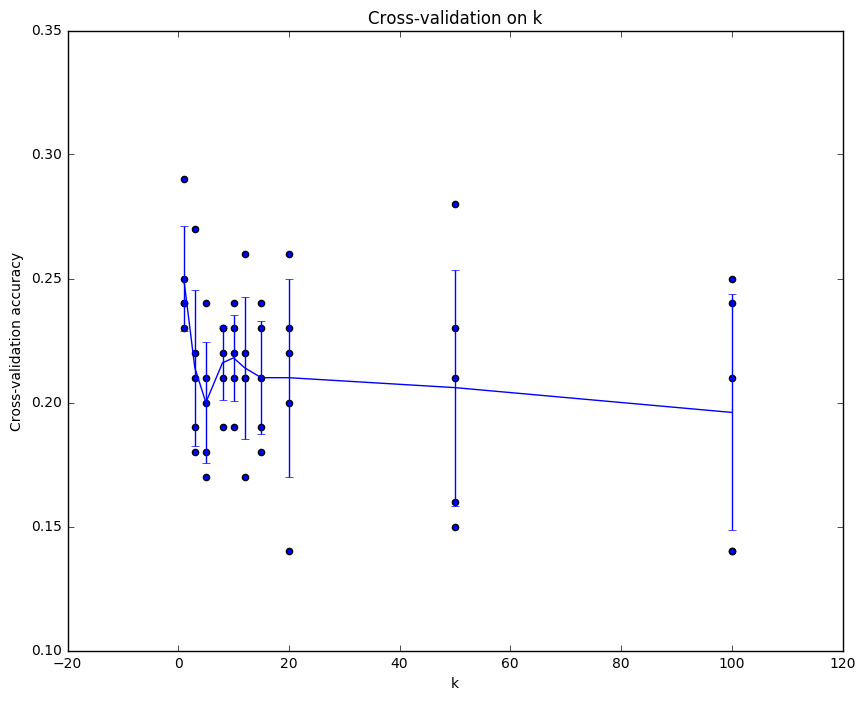

In [68]:
# plot the raw observations
for k in k_choices:
  accuracies = k_to_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()


## Get the Best Value of K 

In [90]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = k_choices[np.argmax(accuracies_mean)]

print ("The best value of K is : %d" % (best_k))
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

The best value of K is : 1
Got 13 / 100 correct => accuracy: 0.130000
